# Lecture 7: Quantum Algorithms

### 7.1 Grover's Algorithm

Grover's Algorithm is a quantum algorithm that helps us find a specific item in an unsorted list much faster than classical algorithms:

Let's begin with a simple math process called reverse around the mean:

In [15]:
random_vector = rand(10)

10-element Vector{Float64}:
 0.1985995879621163
 0.003872597748238671
 0.5543448435005072
 0.7484141376823366
 0.2048406904348712
 0.513171845953691
 0.16084935415639623
 0.5945090360572577
 0.6856902249344735
 0.6555090635500809

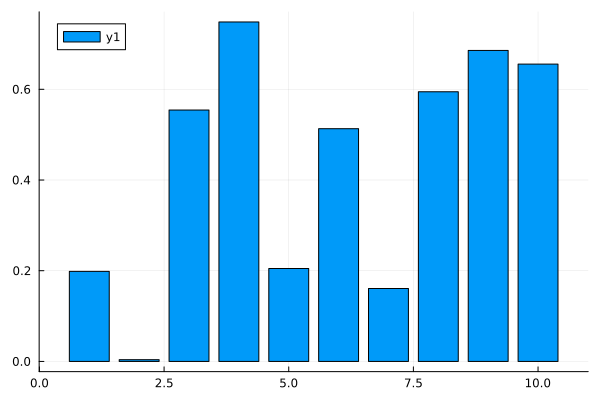

In [16]:
bar(random_vector)

Let's say we want the 6th element to stand out more:

- Calculate the average of all the amplitudes in the quantum register.
- Reflect the amplitudes across the average value.

In [17]:
average_func(x) = sum(x)/length(x)

average_func (generic function with 1 method)

In [19]:
sixth_amplified = copy(random_vector)
sixth_amplified[6] = -sixth_amplified[6]
sixth_amplified = (2 .* mean(sixth_amplified)) .- sixth_amplified

bar(sixth_amplified)

In [20]:
first_amplified = copy(random_vector)
first_amplified[1] = -first_amplified[1]
first_amplified = (2 .* mean(first_amplified)) .- first_amplified

bar(first_amplified)

We can apply the same calculation again, let's do it for the 1st element because it doesn't seem to be that much bigger than the rest.

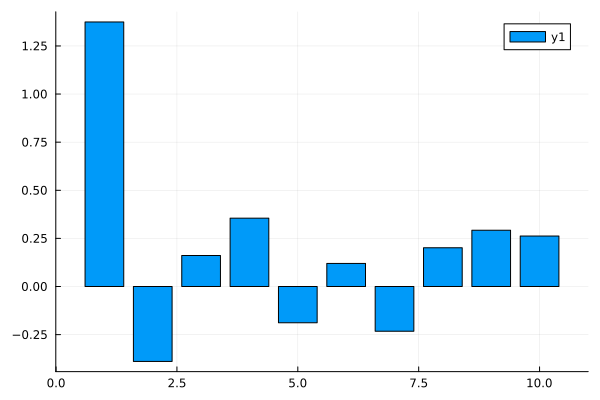

In [21]:
first_amplified = copy(first_amplified)
first_amplified[1] = -first_amplified[1]
first_amplified = (2 .* mean(first_amplified)) .- first_amplified

bar(first_amplified)

In [98]:
first_amplified

10-element Vector{Float64}:
  1.3743924587151053
 -0.3893754139210668
  0.16109683183120171
  0.3551661260130311
 -0.18840732123443427
  0.11992383428438558
 -0.23239865751290922
  0.20126102438795224
  0.29244221326516806
  0.2622610518807754

What we need are 2 circuits:

- one that flips a state
- one that calculate the average and reflects the amplitudes around the average.

The flipping cirucit around state 010

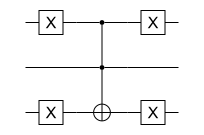

In [36]:
using Yao , YaoPlots

flip_circuit_010 = chain(3,
    put(1=>X),
    put(3=>X),
    control(1:2, 3=>X),
    put(1=>X),
    put(3=>X))
plot(flip_circuit_010)

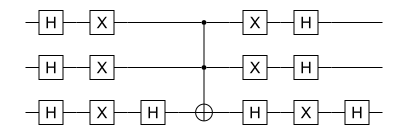

In [31]:
using Yao , YaoPlots

amplitude_circuit = chain(3,
    put(1=>H), put(2=>H), put(3=>H),
    put(1=>X), put(2=>X), put(3=>X),
    put(3=>H),
    control(1:2, 3=>X),
    put(1=>X), put(2=>X), put(3=>H),
    put(1=>H), put(2=>H), put(3=>X),
    put(3=>H))
plot(amplitude_circuit)

And now to combine them:

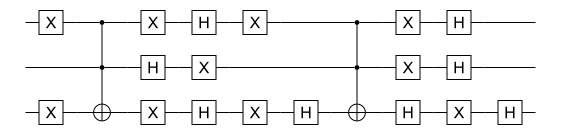

In [60]:
grover = chain(3, 
    put(1:3 => flip_circuit_010),
    put(1:3 => amplitude_circuit)
)
plot(grover)

In [69]:
states_no = 3
output = 0
tries = 0
for i in 1:(2^3)
    input = uniform_state(states_no)
    global output = input |> grover |> r->measure(r, nshots=1000)
    if(output[1] == bit"010")
        tries = tries + 1
        println(output[1])
        println("found the state in ---> " ,tries)
        break
    end
end

010 ₍₂₎
found the state in ---> 1


If we want to find a different state we need a different flipping circuit, this one is for 011

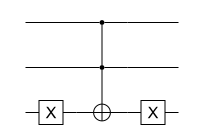

In [45]:
using Yao , YaoPlots

flip_circuit_011 = chain(3,
    put(3=>X),
    control(1:2, 3=>X),
    put(3=>X))
plot(flip_circuit_011)

In [52]:
grover = chain(3, 
    put(1:3 => flip_circuit_011),
    put(1:3 => amplitude_circuit)
)
plot(grover)

In [68]:
states_no = 3
output = 0
tries = 0
for i in 1:(2^3)
    input = uniform_state(states_no)
    global output = input |> grover |> r->measure(r, nshots=1000)
    if(output[1] == bit"011")
        tries = tries + 1
        println(output[1])
        println("found the state in ---> " ,tries)
        break
    end
end

011 ₍₂₎
found the state in ---> 1


### 7.2 Deutsch Algorithm

Consider 4 functions a, b, c and d. Their domain is {0,1} and their codomain is also {0,1} 

- a(0) = 0, a(1) = 0 -> Constant function
- b(0) = 0, b(1) = 1 -> Balanced function
- c(0) = 1, c(1) = 0 -> Balanced function
- d(0) = 1, d(1) = 1 -> Constant function

How many evaluation does it take to prove that a function is either balanced or constant?

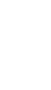

In [71]:
using Yao, YaoPlots


a = chain(2)

plot(a)

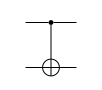

In [76]:
b = chain(2, 
    control(1, 2=>X))
plot(b)

In [77]:
c = chain(2, 
    control(1, 2=>X),
    put(2=>X))
plot(c)

In [78]:
d = chain(2, put(2=>X))
plot(d)

Each of the above circuits coresponds to one of our functions, now we will create an array with all of them.

In [80]:
deutch = [a b c d]

1×4 Matrix{ChainBlock{2}}:
 nqubits: 2
chain
  …  nqubits: 2
chain
└─ put on (2)
   └─ X


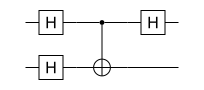

In [93]:
full_circuit = chain(2, 
    repeat(H,1:2), 
    put(1:2=>deutch[r+1]), 
    put(1=>H))

plot(full_circuit)

We will measure circuit b.

In [92]:
input = ArrayReg(bit"10")
circuit_index=1
result = input |> chain(2, 
    repeat(H,1:2), 
    put(1:2=>deutch[circuit_index+1]), 
    put(1=>H)) |> circuit_index->measure(circuit_index,1)

1-element Vector{DitStr{2, 1, Int64}}:
 1 ₍₂₎

In [94]:
result[1] == bit"1" ? "Balanced" : "Constant"

"Balanced"

We will measure circuit a.

In [96]:
input = ArrayReg(bit"10")
circuit_index=0
result = input |> chain(2, 
    repeat(H,1:2), 
    put(1:2=>deutch[circuit_index+1]), 
    put(1=>H)) |> circuit_index->measure(circuit_index,1)

1-element Vector{DitStr{2, 1, Int64}}:
 0 ₍₂₎

In [97]:
result[1] == bit"1" ? "Balanced" : "Constant"

"Constant"

We can generalized this algorithm, in fact we will try and showcase 3 qubits version. The n-qubits version is called the 

In [103]:
qubits_size = 3

3

In [107]:
b = chain(qubits_size+1, [control(index, qubits_size+1=>X) for index in 1:qubits_size])

nqubits: 4
chain
├─ control(1)
│  └─ (4,) X
├─ control(2)
│  └─ (4,) X
└─ control(3)
   └─ (4,) X


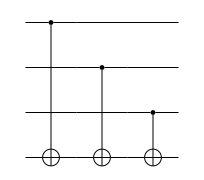

In [108]:
plot(b)

### 7.3 GMZ states.

In [2]:
using Yao, YaoPlots

_pair3Q = uniform_state(3)
state(_pair3Q)

8×1 Matrix{ComplexF64}:
 0.35355339059327373 + 0.0im
 0.35355339059327373 + 0.0im
 0.35355339059327373 + 0.0im
 0.35355339059327373 + 0.0im
 0.35355339059327373 + 0.0im
 0.35355339059327373 + 0.0im
 0.35355339059327373 + 0.0im
 0.35355339059327373 + 0.0im

In [8]:
GHZ_building_block = chain(
    4,
    put(1=>X),
    put(2=>H), put(3=>H), put(4=>H),
    control(2, 1=>X),
    control(4, 3=>X),
    control(3, 1=>X),
    control(4, 3=>X),
    put(1=>H), put(2=>H), put(3=>H), put(4=>H),
    Measure(4, locs=1:4)
)

nqubits: 4
chain
├─ put on (1)
│  └─ X
├─ put on (2)
│  └─ H
├─ put on (3)
│  └─ H
├─ put on (4)
│  └─ H
├─ control(2)
│  └─ (1,) X
├─ control(4)
│  └─ (3,) X
├─ control(3)
│  └─ (1,) X
├─ control(4)
│  └─ (3,) X
├─ put on (1)
│  └─ H
├─ put on (2)
│  └─ H
├─ put on (3)
│  └─ H
├─ put on (4)
│  └─ H
└─ Measure(4;locs=(1, 2, 3, 4))

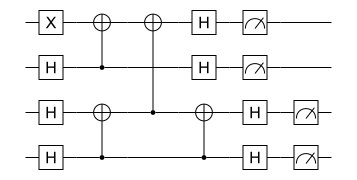

In [9]:
plot(GHZ_building_block)